In [8]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# Assignment 1

## Task 1.1

In order to complete the assignment I use the Ls vs. ML file as a starting point.

The below code generates and plots a polynom based on the parameters.

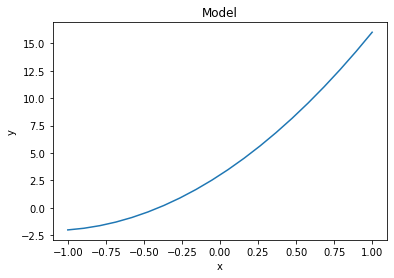

In [67]:
def arbitrary_poly(params):
    poly_model = lambda x: sum([p*(x**i) for i, p in enumerate(params)])
    return poly_model

# params: [theta_0, theta_1, ... , theta_n], where n = model order and theta_0 is bias 
true_params = [3,9,4]
y_model = arbitrary_poly(true_params)

# Plot true model
x = np.linspace(start=-1, stop=1, num=20)
plt.figure()
plt.plot(x, y_model(x))
plt.xlabel("x")
plt.ylabel("y")
plt.title("Model");

## Task 1.2

The below function generates noise 




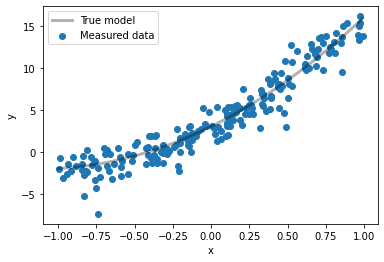

In [81]:

# Hyperparameters for the type of noise-generating distribution.
loc = 0           # location (mean) parameter 
scale = 1         # scaling (std dev) parameter
magnitude = 1.2   # noise magnitude
N = 200          # number of samples

np.random.seed(123)  # Non-random generation between code executions. Comment out for true random

# Generate data points
range_low = -1
range_high = 1
u = np.sort(np.random.uniform(range_low,range_high,N))
y_true = y_model(u)

# Generate noise
from scipy.stats import norm, laplace

laplaceBeta = 1 # Input as the scale parameter in the Laplacian distribution

normVariance = 1 # Input as the scale parameter in the normal distribution

noiseLaplace = magnitude * np.random.laplace(loc, laplaceBeta, N)

noiseGaussian  = magnitude * np.random.normal(loc, normVariance, N)

noiseProbability = 0.5

noiseLaplace = np.random.choice(noiseLaplace, int(N*noiseProbability))

noiseGaussian = np.random.choice(noiseGaussian, int(N*(1-noiseProbability)))
                          
noise = np.concatenate((noiseLaplace, noiseGaussian))
                       
np.random.shuffle(noise)
                       

# Add noise to the generated data points - thus simulating measurement
y = y_true + noise

# Plot measured data
plt.scatter(u, y, label=r"Measured data")
u0 = np.linspace(-1, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

### Measurement noise generation from a chosen distribution
Probability density functions (PDFs):

Gaussian pdf: $P(x) = \frac{1}{\sigma\sqrt{2\pi}}e^{-\frac{1}{2}(\frac{x-\mu}{\sigma})^2}$

Laplacian pdf: $P(x) = \frac{1}{2b}e^{-\frac{|x-\mu|}{b}}$

Hyperparameters to adjust:
- dist: "laplace" or "gauss" : the class of noise-generating distribution.
- mu: The distribution's location parameter (mean value for Gauss).
- sigma: The distribution's scaling parameter (std. for Gauss).
- magnitude: The noise magnitude.
- N: number of samples to generate for the model.

### Data generation:

## Task 1.3

## Least squares regression - LS
### Given the sampled data we can estimate the underlying polynomial model using LS regression
Solution to a least squares problem is given by the normal equation:  
$\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

### Step 1 - rewrite the model in matrix form to get the data tensor u
$y_{measured} = \theta_0  + \theta_1 \cdot u^1 + ... + \theta_n \cdot u^n  + noise =   [1 \; u^1 \; .. \; u^n] \cdot [ \theta_0 \; \theta_1 \; .. \; \theta_n ] ^T + noise$

$\mathbf{u} = [1 \; u^1 \; .. \; u^n]$

In [82]:
# Matrix form
u_tensor_0 = np.reshape(u,(N,1))
print(f"data u :\n{u_tensor_0[0:5]} \n")

ones_vec = np.ones((N,1))
u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

for i in range(2,len(true_params)):
    u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)

print(f"data tensor [1, u, u^2, ... , u^n] :\n{u_tensor[0:5,:]}")

data u :
[[-0.99462387]
 [-0.98514724]
 [-0.96774159]
 [-0.94136055]
 [-0.93560413]] 

data tensor [1, u, u^2, ... , u^n] :
[[ 1.         -0.99462387  0.98927664]
 [ 1.         -0.98514724  0.97051509]
 [ 1.         -0.96774159  0.93652378]
 [ 1.         -0.94136055  0.88615969]
 [ 1.         -0.93560413  0.87535509]]


### Step 2   

calculate $(\mathbf{u}^T \cdot \mathbf{u})^{-1}$

In [83]:
u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse
print(u_transpose_dot_u_inv)

[[ 0.01009391 -0.00041816 -0.0180226 ]
 [-0.00041816  0.01772049  0.00106993]
 [-0.0180226   0.00106993  0.06377471]]


### Step 3  

calculate $(\mathbf{u}^T \cdot \mathbf{y})$

In [84]:
u_transpose_dot_y = np.dot(u_tensor.T,y)  # calculating dot product
print(u_transpose_dot_y)

[806.73871499 520.30169161 280.62133665]


### Step 4 

solve for $\hat{\mathbf{\theta}} = (\mathbf{u}^T\cdot \mathbf{u})^{-1}(\mathbf{u}^T\cdot \mathbf{y})$

LS parameters:         ['2.87', '9.18', '3.91']
True model parameters: [3, 9, 4]
The differnence between the estimated theata and the real Theta is: 
[0.1299999999999999, -0.17999999999999972, 0.08999999999999986]


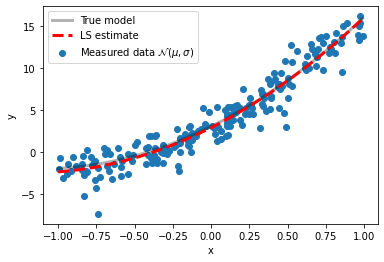

In [85]:
LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in LS_params.tolist()]
print(f"LS parameters:         {LS_params_rounded}")
print(f"True model parameters: {true_params}")

diffParams = []
for i in range(0, len(true_params)):
    diffParams.append(float(true_params[i] - float(LS_params_rounded[i])))

print("The differnence between the estimated theata and the real Theta is: ")

print(diffParams)

# Recreate model based on LS estimate:
LS_params = LS_params.tolist()
LS_estimate = arbitrary_poly(LS_params)

# Plot true vs. estimated model
plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
u0 = np.linspace(-1, max(u), N)
plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
plt.plot(u0, LS_estimate(u0), "r--",  lw=3, label="LS estimate")
#plt.xlim(0, 10)
plt.legend()
plt.xlabel("x")
plt.ylabel("y");

# Task 1.4

## 1. Letting alfa (noiseProbability) be 1, how does d depend on beta?


First I change the parameters from the above simulation to match the ones given in the task:
    
    noiseProbability = 1
    
### Finding d with sigma = 100:

The follwing code both make the noise, the LS solution and calculates the difference beteween the true measurements and LS.
    

LS parameters:         ['3.13', '9.02', '3.90']
True model parameters: [3, 9, 4]
The differnence between the estimated theata and the real Theta is: 
['-0.1', '-0.0', '0.10']


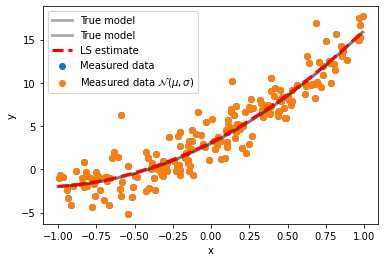

In [97]:
def calculateDifference(alfa, sigma, beta):
    
    laplaceBeta = 1 # Input as the scale parameter in the Laplacian distribution

    normVariance = sigma # Input as the scale parameter in the normal distribution

    noiseLaplace = magnitude * np.random.laplace(loc, laplaceBeta, N)

    noiseGaussian  = magnitude * np.random.normal(loc, normVariance, N)

    noiseProbability = alfa

    noiseLaplace = np.random.choice(noiseLaplace, int(N*noiseProbability))

    noiseGaussian = np.random.choice(noiseGaussian, int(N*(1-noiseProbability)))

    noise = np.concatenate((noiseLaplace, noiseGaussian))

    np.random.shuffle(noise)


    # Add noise to the generated data points - thus simulating measurement
    y = y_true + noise

    # Plot measured data
    plt.scatter(u, y, label=r"Measured data")
    u0 = np.linspace(-1, max(u), N)
    plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y");
    
    # Matrix form
    u_tensor_0 = np.reshape(u,(N,1))

    ones_vec = np.ones((N,1))
    u_tensor = np.append(ones_vec, u_tensor_0, axis=1)

    for i in range(2,len(true_params)):
        u_tensor = np.append(u_tensor, np.power(u_tensor_0, i) ,axis=1)

    u_transpose_dot_u = np.dot(u_tensor.T,u_tensor)  # calculating dot product
    u_transpose_dot_u_inv = np.linalg.inv(u_transpose_dot_u) #calculating inverse

    u_transpose_dot_y = np.dot(u_tensor.T,y)  # calculating dot product

    LS_params = np.dot(u_transpose_dot_u_inv,u_transpose_dot_y)
    LS_params_rounded = ["{:.2f}".format(round(i, 2)) for i in LS_params.tolist()]
    print(f"LS parameters:         {LS_params_rounded}")
    print(f"True model parameters: {true_params}")

    diffParams = []
    for i in range(0, len(true_params)):
        diffParams.append(format(str(float(true_params[i] - float(LS_params_rounded[i]))),".4"))

    print("The differnence between the estimated theata and the real Theta is: ")

    print(diffParams)

    # Recreate model based on LS estimate:
    LS_params = LS_params.tolist()
    LS_estimate = arbitrary_poly(LS_params)

    # Plot true vs. estimated model
    plt.scatter(u, y, label=r"Measured data $\mathcal{N}(\mu, \sigma)$")
    u0 = np.linspace(-1, max(u), N)
    plt.plot(u0, y_model(u0), "k", alpha=0.3, lw=3, label="True model")
    plt.plot(u0, LS_estimate(u0), "r--",  lw=3, label="LS estimate")
    #plt.xlim(0, 10)
    plt.legend()
    plt.xlabel("x")
    plt.ylabel("y");

calculateDifference(1, 100, 1)


### Finding d with sigma = 10:


LS parameters:         ['1.27', '-8.07', '4.17']
True model parameters: [1, -8, 4]
The differnence between the estimated theata and the real Theta is: 
[-0.27, 0.07000000000000028, -0.16999999999999993]


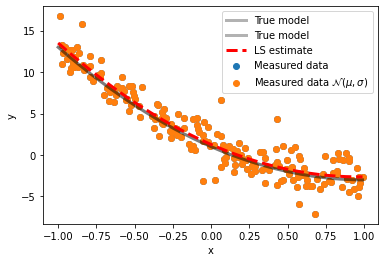

In [60]:
calculateDifference(1, 10, 1)

### Finding d with sigma = 1:

LS parameters:         ['1.12', '-7.99', '4.04']
True model parameters: [1, -8, 4]
The differnence between the estimated theata and the real Theta is: 
[-0.1200000000000001, -0.009999999999999787, -0.040000000000000036]


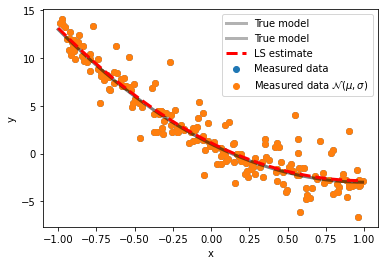

In [54]:
calculateDifference(1, 0, 1)

# 2. Letting alfa (noiseProbability) be 0, how does d depend on beta (laplaceBeta)?

Doing the same as in the last task:

### Finding d with beta = 1:

LS parameters:         ['1.11', '-7.97', '3.97']
True model parameters: [1, -8, 4]
The differnence between the estimated theata and the real Theta is: 
[-0.1100000000000001, -0.03000000000000025, 0.029999999999999805]


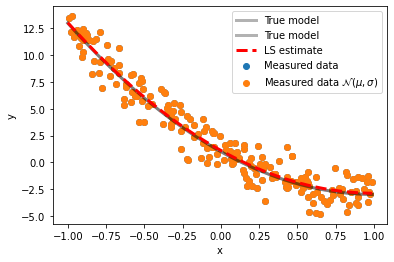

In [55]:
calculateDifference(0, 1, 1)

### Finding d with beta = 0.5:

LS parameters:         ['0.86', '-7.79', '4.27']
True model parameters: [1, -8, 4]
The differnence between the estimated theata and the real Theta is: 
[0.14, -0.20999999999999996, -0.2699999999999996]


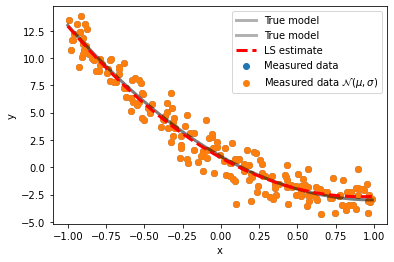

In [56]:
calculateDifference(0, 1, 0.5)

### Finding d with beta = 0:

LS parameters:         ['0.96', '-7.96', '4.16']
True model parameters: [1, -8, 4]
The differnence between the estimated theata and the real Theta is: 
[0.040000000000000036, -0.040000000000000036, -0.16000000000000014]


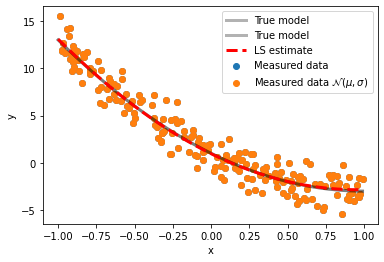

In [57]:
calculateDifference(0, 1, 0)